## Cell generator

In [1]:
import cv2
from cv2 import moments,HuMoments
import pickle
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import sys
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from label_patch import diffusionMap
from patch_normalizer import normalizer
from lib.utils import mark_contours, configuration

### Load parameter file

In [2]:
yamlfile=os.environ['REPO_DIR']+'/shape_params.yaml'
params=configuration(yamlfile).getParams()
print(params)

{'name': 'local', 'paths': {'s3stem': 's3://mousebraindata-open/MD657', 'patches': 'permuted', 'DiffusionMap': '/Users/kuiqian/Github/shapeology_code/notebooks/diffusionMap', 'scripts_dir': '/Users/kuiqian/Github//shapeology_code/scripts', 'data_dir': '/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/'}, 'preprocessing': {'polarity': -1, 'min_std': 10, 'offset': -20, 'min_area': 10}, 'normalization': {'size_thresholds': [15, 51, 201]}}


/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


### Sample display

In [3]:
from glob import glob
from time import time
stack = 'MD594'
patch_dir=os.environ['ROOT_DIR']+'CSHL_patch_samples/'+stack+'/'
structures=[dir for dir in glob(patch_dir+'*')]
patches=[dir for dir in glob(structures[1]+'/*')]
print(patches[0],len(patches))
#structures
n_choose=min(len(patches),1000)
print(n_choose)
indices_choose = np.random.choice(range(len(patches)), n_choose, replace=False)
print(len(indices_choose))
patches = np.array(patches)
patches = patches[indices_choose]
patches[0]

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_samples/MD594/SC/280_0.tif 1686
1000
1000


'/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_samples/MD594/SC/155_6.tif'

In [19]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y

In [5]:
import pandas as pd

In [6]:
patches[0][-7:-4]

'175'

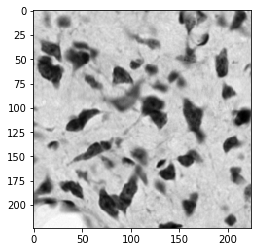

In [38]:
patch=patches[2]
extractor=patch_extractor(params)
gray=cv2.imread(patch,0)
plt.imshow(gray, cmap='gray')

In [39]:
%%time
if params['preprocessing']['polarity']==-1:
    tile = 255-gray
Stats = extractor.segment_cells(tile)
no_blobs,seg,props,location = Stats
cells = extractor.extract_blobs(Stats,tile)

CPU times: user 216 ms, sys: 7.5 ms, total: 224 ms
Wall time: 353 ms


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


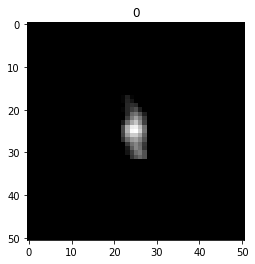

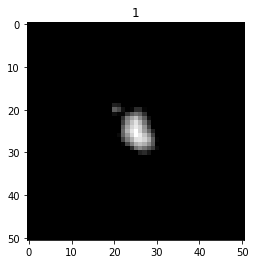

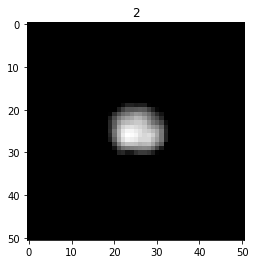

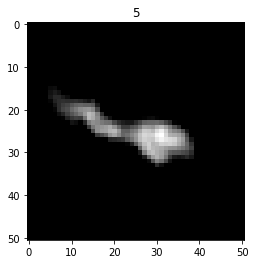

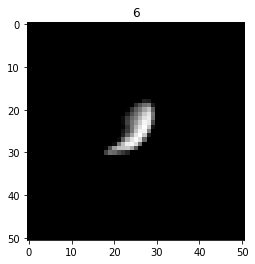

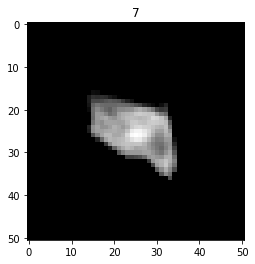

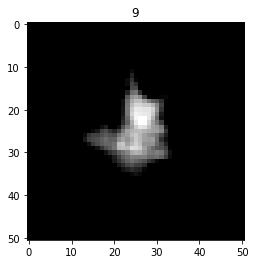

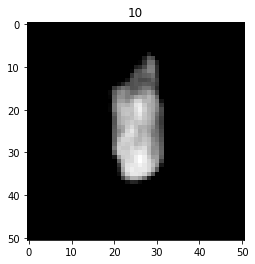

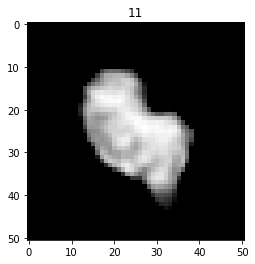

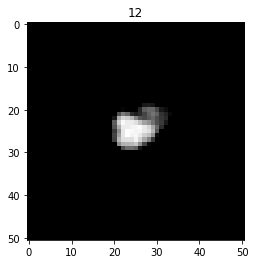

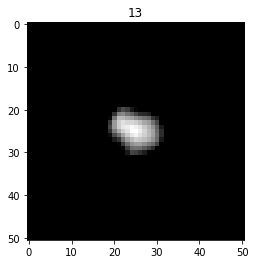

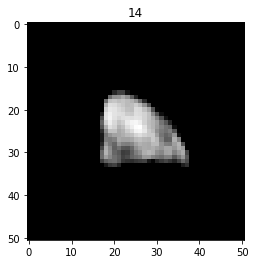

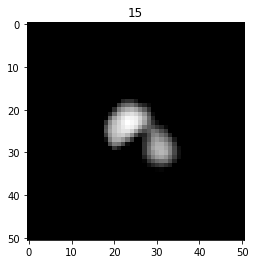

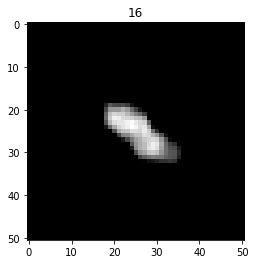

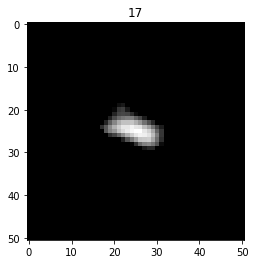

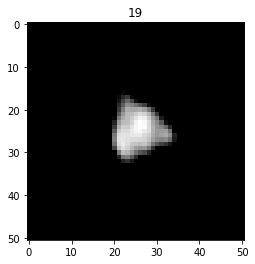

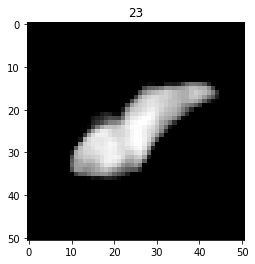

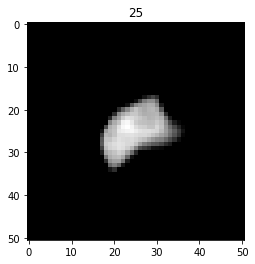

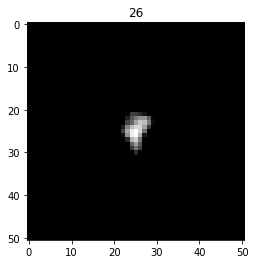

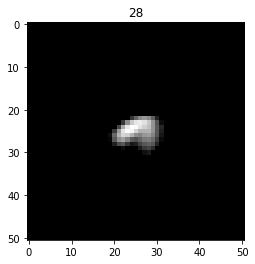

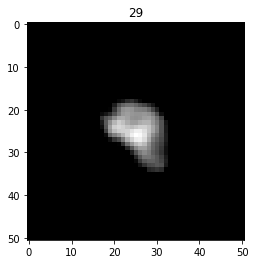

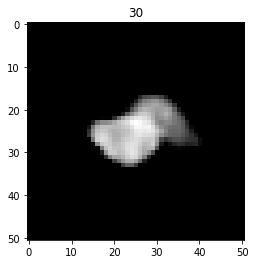

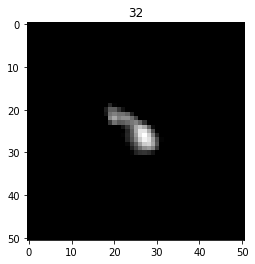

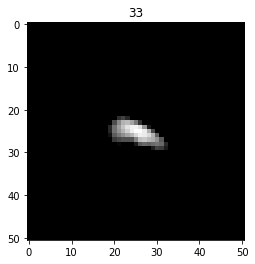

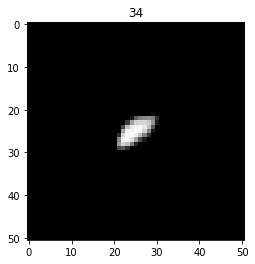

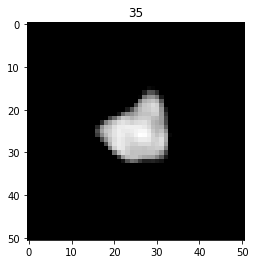

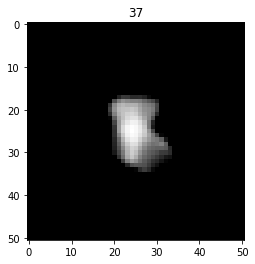

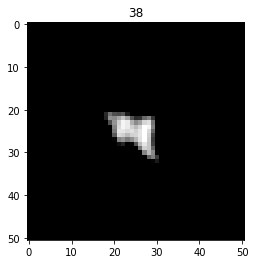

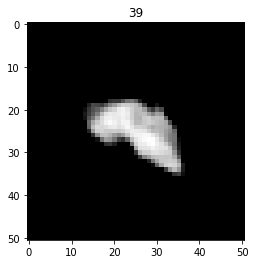

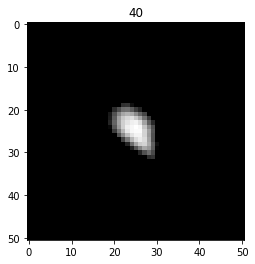

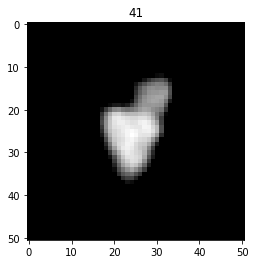

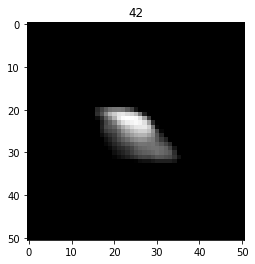

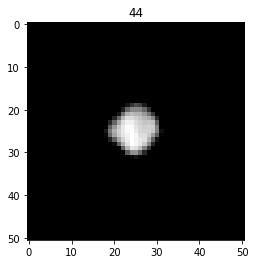

In [124]:
for i in range(len(cells)):
    if cells[i]['padded_size']==51:
        plt.figure()
        plt.imshow(cells[i]['padded_patch'],cmap='gray')
        plt.title(i)

In [147]:
cells[23]

{'left': 34,
 'top': 102,
 'width': 35,
 'height': 23,
 'area': 413,
 'padded_size': 51,
 'padded_patch': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'rotation': -54.94213680142612,
 'rotation_confidence': 5198.796821074174,
 'horiz_std': 3.1124967049796237,
 'vert_std': 8.99829984151845,
 'mean': 11.44856309870887,
 'std': 27.561841393806834,
 'DMVec': array([-1.71344003,  1.43019871, -1.49192216,  0.38858262,  1.22234   ,
         0.61105252, -0.59403753, -0.6936982 , -0.63188636,  0.23214697,
         0.04119776,  0.55138674, -0.15288655, -0.12143326,  0.77166799,
        -1.21246081,  0.28721656,  0.66497385, -0.14315461, -0.25094064,
         0.04952955,  1.04428869,  0.75577786, -0.24798972, -0.23863525,
         0.28908324,  0.27374449,  0.11762578, -0.66360717, -0.0579224 ,
  

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


CPU times: user 47.2 ms, sys: 14.1 ms, total: 61.3 ms
Wall time: 45.2 ms


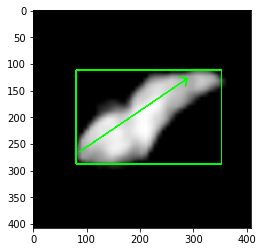

In [189]:
%%time
from skimage.transform import rescale
i = 23
cell = cells[i]['padded_patch']
angle = cells[i]['rotation']*np.pi/180.
M = cv2.moments(cell)
x=int(M['m10']/M['m00']-15*np.sin(angle))
y=int(M['m01']/M['m00']-15*np.cos(angle))
x_ = int(x + 30*np.sin(angle))
y_ = int(y + 30*np.cos(angle))
width = cells[i]['width']
left = int((51-width)/2)+2
right = left + width -1
height = cells[i]['height']
top = int((51-height)/2)
down = top + height-1
scale = 8
cell = rescale(cell,scale,anti_aliasing=True)
cell = cell/cell.max()*255
cell = cell.astype(np.uint8)
color = cv2.cvtColor(cell,cv2.COLOR_GRAY2RGB)
# contours, hierarchy = cv2.findContours(cell, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# convex_contour=cv2.convexHull(contours[0][:,0,:],returnPoints=True)
# cv2.drawContours(color, contours,0,(0,255,0),1)
color = cv2.rectangle(color.copy(), (scale*left,scale*top), (scale*right, scale*down), [0,255,0],2)
color = color.astype(np.uint8)
cv2.arrowedLine(color, (scale*x_, scale*y_), (scale*x,scale*y), [0,255,0],2,cv2.LINE_AA,0,0.06)
plt.imshow(color, cmap='gray')
cv2.imwrite('Features_template.tif', color)

In [167]:
color.max()

255.0

In [121]:
np.sin(angle), np.cos(angle)

(0.7737906449634337, 0.6334414241009765)

In [114]:
M = cv2.moments(cell)
x=M['m10']/M['m00']
y=M['m01']/M['m00']
x,y

(99.82082324455206, 100.24681476468909)

In [109]:
convex_contour.shape

(16, 1, 2)

In [8]:
%%time
tile=cv2.imread(patch,0)
contours, _ = cv2.findContours(tile.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
object_area = cv2.contourArea(contours[0])
if params['preprocessing']['polarity']==-1:
    tile = 255-tile
min_std=params['preprocessing']['min_std']
_std = np.std(tile.flatten())
extracted = []
if _std < min_std:
    print('image',patch,'std=',_std, 'too blank, skipping')
else:
    #t0=time()
    #print('processing',patches[0],'into',pkl_out_file)
    Stats = extractor.segment_cells(tile)
    cells = extractor.extract_blobs(Stats,tile)
    cells = pd.DataFrame(cells)
    cells = cells[cells['padded_patch'].notnull()]
    cells = cells.drop(['padded_patch','left','top'],1)
    columns = cells.columns
    cells = np.asarray(cells)
    for i in range(len(cells)):
        cells[i][0] = cells[i][0][:10]
    origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
    for i in range(origin.shape[1]):
        x, y = CDF(origin[:,i])
        ten = [x[np.argmin(np.absolute(y-0.1*(k+1)))] for k in range(10)]
        extracted.extend(ten)
    extracted.extend([cells.shape[0]/object_area])

CPU times: user 5.63 s, sys: 173 ms, total: 5.8 s
Wall time: 1.36 s


In [9]:
columns

Index(['DMVec', 'area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width'],
      dtype='object')

In [94]:
cv2.drawContours(tile, contours, -1, (0,255,0), -1)
plt.imshow(tile,cmap='gray')

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [96]:
cv2.contourArea(contours[0])

37741.0

In [276]:
features = []
for patch in patches:
    print(patch)
    extractor=patch_extractor(patch,params)
    tile=cv2.imread(patch,0)
    contours, _ = cv2.findContours(tile.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)==1:
        object_area = cv2.contourArea(contours[0])
    else:
        object_area = cv2.contourArea(contours[-1])
    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())
    extracted = []
    if _std < min_std:
        print('image',patch,'std=',_std, 'too blank, skipping')
    else:
        #t0=time()
        #print('processing',patches[0],'into',pkl_out_file)
        Stats = extractor.segment_cells(tile)
        cells = extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        cells = cells.drop(['padded_patch','left','top'],1)
        #columns = cells.columns
        cells = np.asarray(cells)
        for i in range(len(cells)):
            cells[i][0] = cells[i][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        for i in range(origin.shape[1]):
            x, y = CDF(origin[:,i])
            ten = [x[np.argmin(np.absolute(y-0.1*(k+1)))] for k in range(10)]
            extracted.extend(ten)
        extracted.extend([cells.shape[0]/object_area])
        features.append(extracted)

/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/175.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/177.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/176.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/179.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/178.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/180.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/181.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/184.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/182.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/183.tif
/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/185.tif

In [273]:
patch = patches[-4]
tile=cv2.imread(patch,0)
contours, _ = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
areas=[]
for j in range(len(contours)):
    areas.extend([cv2.contourArea(contours[j])])

In [274]:
areas = np.sort(areas)

In [275]:
areas[-1]-areas[-2]

2495609.0

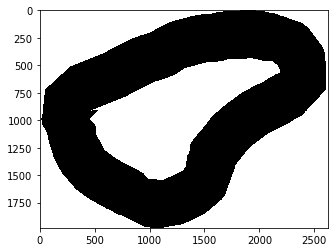

In [256]:
tile = 255-tile
cv2.drawContours(tile, contours, -1, (0,255,0), -1)
plt.imshow(tile,cmap='gray')


In [21]:
import pandas as pd

In [62]:
cells = pd.DataFrame(cells)
cells = cells[cells['padded_patch'].notnull()]


In [63]:
cells = cells.drop('padded_patch',1)
cells.shape

(322, 13)

In [57]:
imgs = cells[['padded_size','padded_patch']]
len(cells)

322

In [27]:
for i in range(len(extracted1)):
    try:
        if extracted1[i]['padded_patch']==None:
            print(i)
    except:
        continue

410


377


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


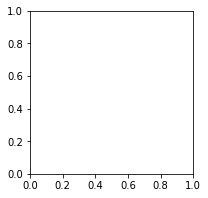

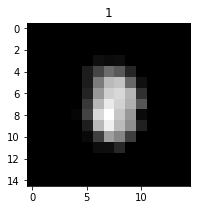

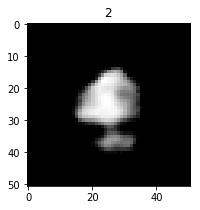

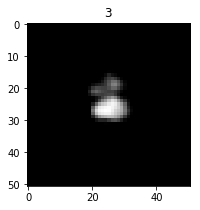

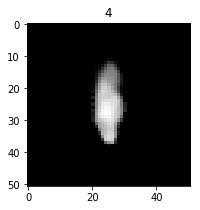

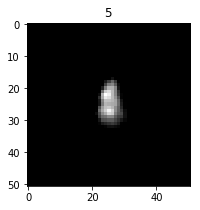

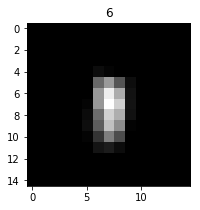

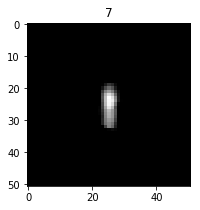

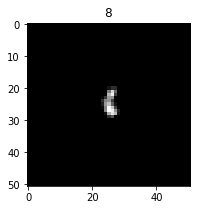

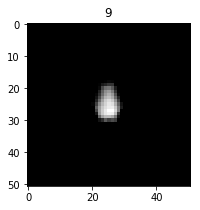

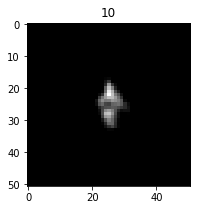

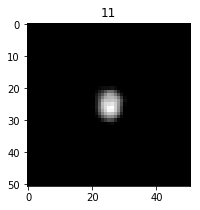

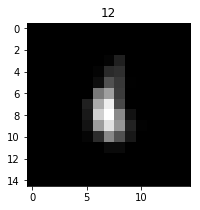

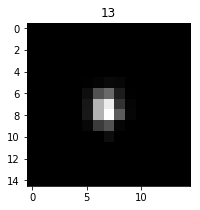

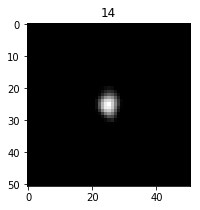

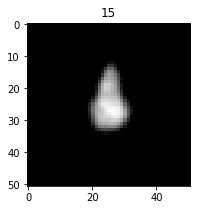

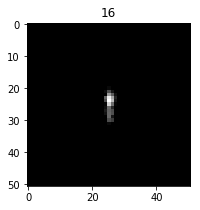

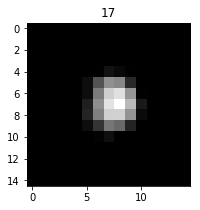

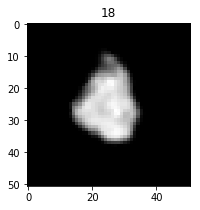

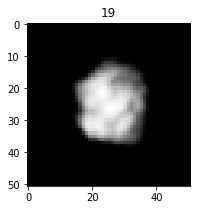

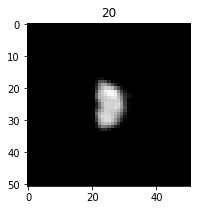

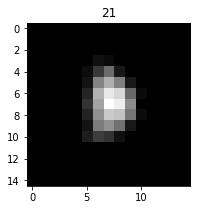

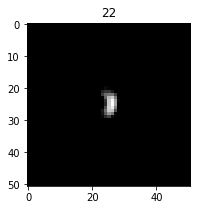

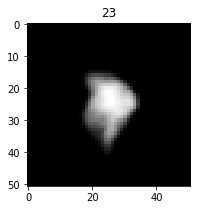

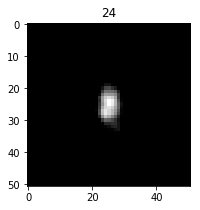

In [32]:
for i in range(len(extracted)):
    try: 
        plt.figure( figsize=(3,3) )
        plt.imshow( extracted[i]['padded_patch'], cmap='gray')
        plt.title(str(i))
    except:
        print(extracted[i]['padded_size'])
        continue

In [25]:
extractor=patch_extractor(patches[1],params)
tile=cv2.imread(patches[1],0)
if params['preprocessing']['polarity']==-1:
    tile = 255-tile
min_std=params['preprocessing']['min_std']
_std = np.std(tile.flatten())

if _std < min_std:
    print('image',patches[1],'std=',_std, 'too blank, skipping')
else:
    #t0=time()
    #print('processing',patches[0],'into',pkl_out_file)
    Stats=extractor.segment_cells(tile)
    extracted2= extractor.extract_blobs(Stats,tile)

/data/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator NearestNeighbors from version 0.20.0 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [26]:
valid=[]
valid.extend(extracted1)
print(len(valid),len(extracted1))
valid.extend(extracted2)
print(len(valid),len(extracted2))

36 36
72 36


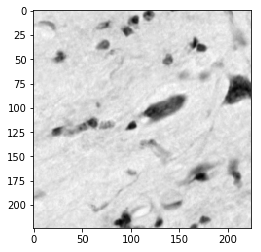

In [31]:
filename='/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/5N/160_382.tif'
img=cv2.imread(filename,0)
plt.imshow(img,cmap='gray')

In [8]:
for i in range(len(extracted)):
    print(str(extracted[i]['padded_size']))

81
81
81
81
81
81
15
81
15
81
15
81
81
81
15
81
81
81
81
81
81
81
15
81
81
81


### Loop for transferring all patches into cells

In [21]:
stack = 'MD589'
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures
patch_dir=os.environ['ROOT_DIR']+'CSHL_patches/'+stack+'/'
! mkdir $ROOT_DIR/CSHL_cells
cell_dir = os.environ['ROOT_DIR']+'CSHL_cells/'+stack+'/'
print(cell_dir)
! mkdir $cell_dir

mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_cells: File exists
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_cells/MD589/
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_cells/MD589/: File exists


In [10]:
from time import time
from skimage import img_as_ubyte

In [11]:
t0=time()

for structure in all_structures:
    if not os.path.exists(patch_dir+structure):
        print('SKIPPING: '+structure)
        continue
    for state in ['positive','negative']:
        if state=='positive':
            patches = [dir for dir in glob(patch_dir+structure+'/*')]
        else:
            patches = [dir for dir in glob(patch_dir+structure+'_surround_200um_noclass/*')]
        savepath = cell_dir+structure+'/'
        ! mkdir $savepath
        savepath = savepath+state+'/'
        if os.path.exists(savepath):
            print(structure+' ALREADY EXIST')
            continue
        else:
            ! mkdir $savepath
            ! mkdir $savepath/15
            ! mkdir $savepath/81
            ! mkdir $savepath/251
        count=0
        for i in range(len(patches)):
            extractor=patch_extractor(patches[i],params)
            tile=cv2.imread(patches[i],0)
            if params['preprocessing']['polarity']==-1:
                tile = 255-tile
            min_std=params['preprocessing']['min_std']
            _std = np.std(tile.flatten())

            if _std < min_std:
                print('image',patches[i],'std=',_std, 'too blank, skipping')
            else:
                Stats=extractor.segment_cells(tile)
                extracted= extractor.extract_blobs(Stats,tile)
                for j in range(len(extracted)):
                    try:
                        filename=savepath+str(extracted[j]['padded_size'])+'/'+str(count)+'.tif'
                        count+=1
                        img=extracted[j]['padded_patch']
                        img=img/img.max()*255
                        img=img.astype(np.uint8)
                        cv2.imwrite(filename, img)
                    except:
                        continue
            if count>100000:
                break
    print(structure+'finished in %5.1f seconds'%(time()-t0))
    

mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_cells/MD589/5N/: File exists
5Nfinished in 190.5 seconds
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_cells/MD589/6N/: File exists
6Nfinished in 231.0 seconds
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N/203_6.tif std= 8.923340435157714 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N/200_50.tif std= 8.289167142416543 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N/262_7.tif std= 9.62164153032683 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N/201_4.tif std= 9.33244877809078 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N/198_58.tif std= 9.712157580026192 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N/262_10.tif std= 9.643634504543712 too blank, skipping

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N_surround_200um_noclass/186_132.tif std= 9.081437314667786 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N_surround_200um_noclass/178_144.tif std= 9.248597785479252 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N_surround_200um_noclass/158_117.tif std= 9.547448076236044 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N_surround_200um_noclass/314_178.tif std= 7.022390376316507 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N_surround_200um_noclass/184_157.tif std= 7.256330955542672 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N_surround_200um_noclass/304_144.tif std= 9.841136994146822 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/7N_surroun

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/LC_surround_200um_noclass/266_646.tif std= 4.854170683284729 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/LC_surround_200um_noclass/184_597.tif std= 3.2967565516994575 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/LC_surround_200um_noclass/265_626.tif std= 2.5773040639587714 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/LC_surround_200um_noclass/265_632.tif std= 2.5467362782211094 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/LC_surround_200um_noclass/265_633.tif std= 2.603926280433825 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/LC_surround_200um_noclass/184_596.tif std= 3.930188528959263 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/LC_surr

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/205_282.tif std= 3.482133206974861 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/207_152.tif std= 3.8207507749135283 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/276_668.tif std= 6.464600559145526 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/282_669.tif std= 2.9836302507773635 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/225_5.tif std= 5.0812961797058485 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/260_188.tif std= 3.7244202865159033 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surro

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/185_386.tif std= 3.8511480551513015 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/257_831.tif std= 7.158315059621579 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/252_64.tif std= 4.527226990871774 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/200_44.tif std= 4.14239497208384 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/266_324.tif std= 5.0326513915577955 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/193_472.tif std= 3.15931444177317 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/200_112.tif std= 8.58069762916326 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/204_536.tif std= 4.53780882287286 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/257_170.tif std= 9.94352168050362 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/206_180.tif std= 4.039812864207708 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/180_228.tif std= 8.452236958884875 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/219_273.tif std= 1.4669630666114015 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/274_157.tif std= 3.927563599192517 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/201_249.tif std= 3.3770596135972144 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/198_212.tif std= 3.097023231753502 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/275_344.tif std= 3.212297977030437 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/213_833.tif std= 8.388115905941293 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/259_86.tif std= 3.3502870276747676 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surrou

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/224_161.tif std= 4.183316174407928 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/248_678.tif std= 7.980768256665289 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/272_310.tif std= 4.607903510481072 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/245_129.tif std= 4.289849944446602 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/213_358.tif std= 3.50775970398786 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/290_397.tif std= 7.794004378149758 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/219_105.tif std= 1.8185593405058311 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/285_239.tif std= 7.391600036759392 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/251_294.tif std= 8.633947687068282 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/225_399.tif std= 4.306324201069833 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/218_5.tif std= 3.747993916172491 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/280_368.tif std= 4.068627693929785 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/219_138.tif std= 1.54177108045439 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/223_2.tif std= 4.337188677157609 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/262_339.tif std= 3.2177744365535514 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/213_403.tif std= 3.1596941469658812 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/212_79.tif std= 3.762929723983355 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/187_309.tif std= 3.3891873580945195 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/194_590.tif std= 8.897794550126324 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/224_612.tif std= 4.45400860869683 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/275_184.tif std= 4.977288386771008 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/225_401.tif std= 4.0345575317046185 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/272_463.tif std= 4.820393652482859 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/205_122.tif std= 2.9120676869661932 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surrou

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/207_231.tif std= 5.605226160972285 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/255_464.tif std= 3.684713080708015 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/202_68.tif std= 3.0989540554641577 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/218_30.tif std= 4.894705179960683 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/218_24.tif std= 4.21325430821979 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/217_231.tif std= 3.2157701362174156 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/268_212.tif std= 5.208611168715543 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/273_68.tif std= 9.945432058214125 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/185_422.tif std= 3.9363691752988097 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/270_360.tif std= 3.233178831724429 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/245_289.tif std= 4.284922197165252 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/247_159.tif std= 3.753182025210368 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surroun

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/259_287.tif std= 8.445929196549319 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/192_489.tif std= 4.168653331651577 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/246_174.tif std= 4.388793503069105 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/261_359.tif std= 4.557225599946008 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/217_184.tif std= 3.177522461223463 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/252_544.tif std= 4.444958819561055 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surroun

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/280_1.tif std= 9.45288424005942 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/197_533.tif std= 4.425530719192109 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/217_49.tif std= 3.625991873780687 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/262_271.tif std= 3.261879348756008 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/256_15.tif std= 1.6170105163988875 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_200um_noclass/197_255.tif std= 3.5843695390748733 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Pn_surround_2

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Tz_surround_200um_noclass/267_445.tif std= 7.779763553439634 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Tz_surround_200um_noclass/263_56.tif std= 8.986957919186944 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Tz_surround_200um_noclass/252_225.tif std= 7.597260923813995 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Tz_surround_200um_noclass/211_13.tif std= 9.904751566295895 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Tz_surround_200um_noclass/217_222.tif std= 9.640232323304433 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Tz_surround_200um_noclass/253_354.tif std= 9.389486263740968 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/Tz_surround_

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VLL_surround_200um_noclass/131_403.tif std= 9.085656652581307 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VLL_surround_200um_noclass/134_234.tif std= 9.781640227421953 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VLL_surround_200um_noclass/317_250.tif std= 8.171877472177103 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VLL_surround_200um_noclass/156_87.tif std= 9.689730516285012 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VLL_surround_200um_noclass/151_71.tif std= 9.862226308738276 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VLL_surround_200um_noclass/167_302.tif std= 3.776091508042477 too blank, skipping
VLLfinished in 1413.6 seconds
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_

/Users/kuiqian/Github/MouseBrainAtlas_dev/shapeology/scripts/patch_normalizer.py:11: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(x**2,_sum)-np.dot(x,_sum)**2)


image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/SNR_surround_200um_noclass/184_585.tif std= 9.132638381717442 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/SNR_surround_200um_noclass/165_402.tif std= 6.635131939466323 too blank, skipping
SNRfinished in 1911.9 seconds
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_cells/MD589/3N/: File exists
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/3N_surround_200um_noclass/230_393.tif std= 9.97404818152323 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/3N_surround_200um_noclass/217_382.tif std= 8.297314001784985 too blank, skipping
3Nfinished in 2068.9 seconds
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_cells/MD589/4N/: File exists
4Nfinished in 2139.5 seconds
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_cells/MD589/Sp5I/: File exists
image /Users/kuiqian/BstemAtlasDa

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/100_17.tif std= 3.9828290720750084 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/111_137.tif std= 8.766742902484202 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/361_267.tif std= 3.604146962368661 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/114_62.tif std= 8.709304522867853 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/111_85.tif std= 4.986748864128463 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/120_203.tif std= 8.756275080815232 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_su

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/365_30.tif std= 4.325582005700321 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/365_18.tif std= 7.6430186753274985 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/346_103.tif std= 8.773705372926457 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/122_105.tif std= 7.790740045875294 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/105_26.tif std= 5.199768129457061 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/362_11.tif std= 4.510569829480769 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_sur

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/117_24.tif std= 8.644905643885547 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/363_47.tif std= 9.467464657253315 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/360_275.tif std= 3.966276797796397 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/110_11.tif std= 7.930294586718076 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/104_64.tif std= 4.777146669648278 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surround_200um_noclass/110_131.tif std= 4.535555807411643 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCA_surr

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/122_88.tif std= 9.510148641873775 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/117_33.tif std= 7.36724612949714 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/351_220.tif std= 5.383902573643893 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/351_208.tif std= 8.278572023528188 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/342_320.tif std= 2.1928154899820402 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/347_271.tif std= 7.7568038562314285 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_s

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/335_16.tif std= 7.737362288391872 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/342_322.tif std= 1.1063906854502734 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/107_158.tif std= 5.505858419671286 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/117_19.tif std= 7.760162168909473 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/349_185.tif std= 3.875188766207145 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/346_504.tif std= 5.034090112576267 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_s

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/354_189.tif std= 4.232408074398893 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/346_503.tif std= 5.01473271973146 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/117_22.tif std= 9.712441802004872 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/117_36.tif std= 7.793043480094664 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/122_277.tif std= 9.993934557257655 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_surround_200um_noclass/349_196.tif std= 4.169356321406706 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/VCP_sur

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/DC_surround_200um_noclass/309_204.tif std= 8.205104876004484 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/DC_surround_200um_noclass/320_35.tif std= 8.297669102109305 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/DC_surround_200um_noclass/314_233.tif std= 9.970540116649081 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/DC_surround_200um_noclass/109_469.tif std= 5.158382882591212 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/DC_surround_200um_noclass/111_527.tif std= 8.136407118917246 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/DC_surround_200um_noclass/138_199.tif std= 6.44443259003957 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/DC_surround_

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/226_82.tif std= 3.2614067285483115 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/219_58.tif std= 1.6847079464913173 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/217_75.tif std= 2.8016378998246796 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/217_77.tif std= 5.226566291296191 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/222_27.tif std= 3.857163000924371 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/227_4.tif std= 4.79605913506398 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/225_66.tif std= 5.291299570780794 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/216_57.tif std= 3.7595390052461006 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/218_52.tif std= 3.7700172808058157 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/226_4.tif std= 3.330030635112636 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/218_85.tif std= 3.160584161903032 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/220_56.tif std= 6.87925919638326 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200u

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/218_43.tif std= 3.6777504400519274 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/226_1.tif std= 3.5097475691953215 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/223_16.tif std= 4.108976372853062 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/230_56.tif std= 3.4898807702776122 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/224_37.tif std= 2.818550926587554 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/229_88.tif std= 3.6892749320050267 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_2

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/228_29.tif std= 3.0395608420245934 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/218_61.tif std= 3.5261964884573223 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/216_64.tif std= 3.8659692567044317 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/223_34.tif std= 4.252677018062791 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/228_4.tif std= 3.572173501168488 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/227_93.tif std= 3.0709629219262244 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_2

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/217_57.tif std= 4.489462307821964 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/217_47.tif std= 2.5353194146132583 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/225_22.tif std= 4.21096823712646 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/226_73.tif std= 8.129938141265276 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/223_56.tif std= 9.208321296955743 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um_noclass/229_6.tif std= 9.085422864174967 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/AP_surround_200um

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/SC_surround_200um_noclass/217_152.tif std= 9.925575996317237 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/SC_surround_200um_noclass/213_576.tif std= 2.7990277299863413 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/SC_surround_200um_noclass/276_1164.tif std= 6.949276104830492 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/SC_surround_200um_noclass/216_427.tif std= 1.9962976377647192 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/SC_surround_200um_noclass/224_1070.tif std= 5.275529617659641 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/SC_surround_200um_noclass/217_807.tif std= 6.8130425946594215 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/SC_su

image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/IC_surround_200um_noclass/171_608.tif std= 2.9733704018894223 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/IC_surround_200um_noclass/169_593.tif std= 9.40659376221118 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/IC_surround_200um_noclass/231_346.tif std= 2.4854303126349726 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/IC_surround_200um_noclass/195_386.tif std= 2.970004090395993 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/IC_surround_200um_noclass/224_217.tif std= 9.763570524578155 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/IC_surround_200um_noclass/193_314.tif std= 2.1268830796467872 too blank, skipping
image /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_patches/MD589/IC_surro